In [6]:
from openbb import obb
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt

In [7]:
obb.account.login(email = "your_email_here", password = "your_pw_here", remember_me = True)

In [13]:
data = obb.equity.price.historical('AAPL', start_date = "2000-01-01").to_df()

data.tail(5)

,open,high,low,close,volume,vwap,label,adj_close,unadjusted_volume,change,change_percent,change_over_time
date,,,,,,,,,,,,
2023-12-22,195.18,195.41,192.9700,193.60,37149570,194.10,"December 22, 23",193.60,37122800.0,-1.58,-0.80951,-0.008095
2023-12-26,193.61,193.89,192.8300,193.05,28919310,193.17,"December 26, 23",193.05,28919300.0,-0.56,-0.28924,-0.002892
2023-12-27,192.49,193.50,191.0900,193.15,48087681,192.57,"December 27, 23",193.15,48087700.0,0.66,0.34287,0.003429
2023-12-28,194.14,194.66,193.1700,193.58,33751371,193.92,"December 28, 23",193.58,33057853.0,-0.56,-0.28845,-0.002884
2023-12-29,193.90,194.39,191.9099,191.95,9398773,192.75,"December 29, 23",191.95,9398773.0,-1.95,-1.00567,-0.010057


/var/folders/_j/klg8v4d93_qd2ljgd068np4r0000gn/T/ipykernel_89973/1789522956.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Signal'] = predictions
/var/folders/_j/klg8v4d93_qd2ljgd068np4r0000gn/T/ipykernel_89973/1789522956.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Position'] = test_data['Predicted_Signal'].shift(1)
/var/folders/_j/klg8v4d93_qd2ljgd068np4r0000gn/T/ipykernel_89973/1789522956.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Final Portfolio Value: $14258.73


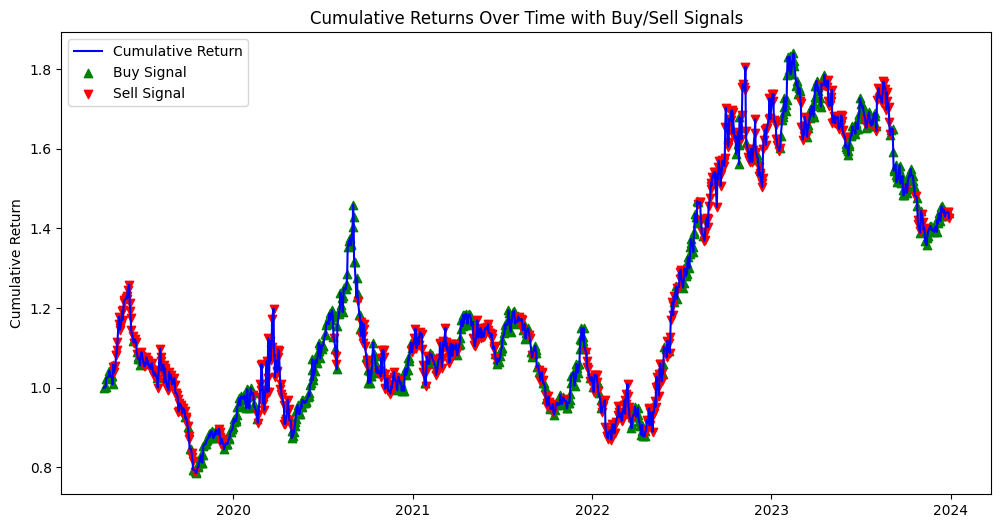

In [18]:
# Define parameters
initial_capital = 10000  # Initial capital
capital = initial_capital
position = 0  # Number of shares held
lookback_window = 20  # Number of past days used for feature engineering
n_estimators = 100  # Number of boosting rounds

# Feature engineering
data['SMA'] = data['close'].rolling(lookback_window).mean()
data['RSI'] = 100 - (100 / (1 + (
    data['close'].diff(1).apply(lambda x: 1 if x > 0 else 0).rolling(lookback_window).sum() / lookback_window)))

# Create target variable (1 for buy, -1 for sell, 0 for hold)
data['Signal'] = np.where(data['close'] > data['SMA'], 1, -1)

# Drop rows with NaN values
data.dropna(inplace=True)

# Split data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Define X and y
X_train = train_data[['SMA', 'RSI']].values
y_train = train_data['Signal'].values
X_test = test_data[['SMA', 'RSI']].values

# Create and train the GradientBoostingClassifier model
model = GradientBoostingClassifier(n_estimators=n_estimators)
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Backtesting the strategy
test_data['Predicted_Signal'] = predictions
test_data['Position'] = test_data['Predicted_Signal'].shift(1)

# Calculate daily returns
test_data['Daily_Return'] = test_data['close'].pct_change() * test_data['Position']
test_data['Cumulative_Return'] = (1 + test_data['Daily_Return']).cumprod()
test_data['Portfolio_Value'] = initial_capital * test_data['Cumulative_Return']

# Print the final portfolio value
final_portfolio_value = test_data['Portfolio_Value'].iloc[-1]
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Cumulative_Return'], label='Cumulative Return')
plt.scatter(
    test_data.index[test_data['Predicted_Signal'] == 1],
    test_data['Cumulative_Return'][test_data['Predicted_Signal'] == 1],
    marker='^',
    color='g',
    label='Buy Signal')
plt.scatter(
    test_data.index[test_data['Predicted_Signal'] == -1],
    test_data['Cumulative_Return'][test_data['Predicted_Signal'] == -1],
    marker='v',
    color='r',
    label='Sell Signal')
plt.title('Cumulative Returns Over Time with Buy/Sell Signals')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()